In [1]:
import app.calibration as cal
import app.edges as e
import app.warp as w
import app.lane_finder as lf
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

loaded


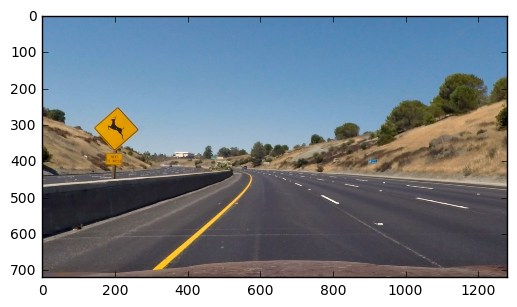

In [2]:
calibrator = cal.Camera_calibrator()
calibrator.initialize()

img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = calibrator.calibrate(img)

plt.imshow(undist)

In [3]:
edges = e.Edges(undist) 
gx_im = edges.gradient_x()
gc_im = edges.gradient_color_channel()

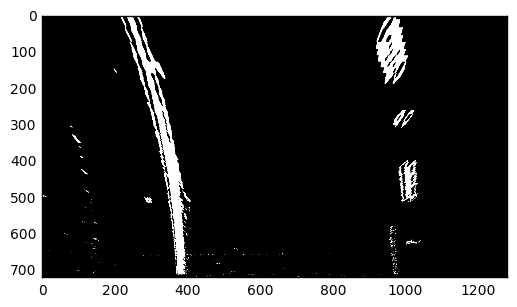

In [4]:
warped = w.warp(edges.combined)
plt.imshow(warped, cmap='gray')

In [5]:
lane_detector = lf.LaneDetector(warped)

C:\workspace\studies\udacity\self driving car\advanced lane detection\CarND-Advanced-Lane-Lines\app\lane_finder.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.histogram = np.sum(self.binary[self.binary.shape[0]/2:, :], axis=0)


In [6]:
left_fit, right_fit, left_lane_inds, right_lane_inds = lane_detector.find_lanes()

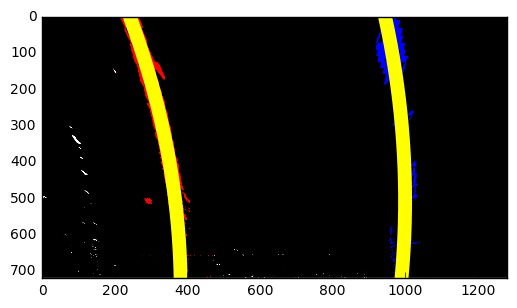

In [10]:
marked = lf.plot_lanes(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

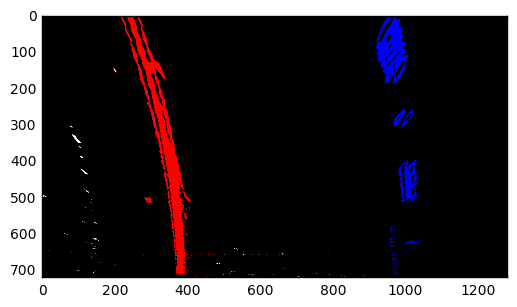

In [11]:
plt.imshow(marked)

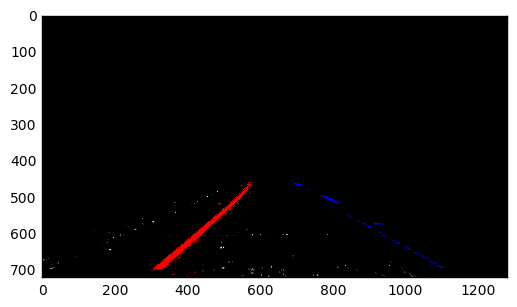

In [8]:
unwarped = w.unwarp(marked)
plt.imshow(unwarped)

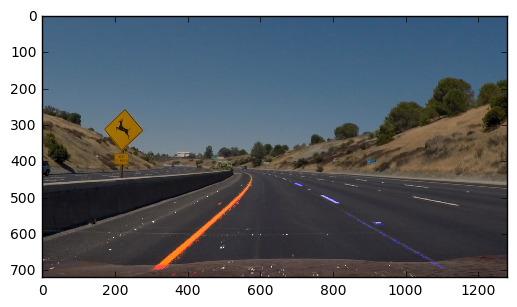

In [9]:
final = cv2.addWeighted(img,0.7,unwarped,0.8,0)
plt.imshow(final)